## Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.

**Цель проекта:** изучить имеющиеся исторические данные одного из регионов и построить модель, предсказывающую вероятность ДТП.

**Задачи:**
- Выгрузить необходимые данные
- Провести исследование данных
- Провести статистический анализ факторов ДТП
- Построить модели для предсказания риска ДТП
- Провести анализ факторов ДТП
- Сделать выводы


## Подключимся к базе. Загрузим таблицы sql

In [1]:
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import random
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import torch.nn as nn
import torch 
import torch.nn.functional as F
import numpy as np

In [2]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)

In [2]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'pwd', # пароль,
'host': 'host',
'port': 1234, # порт подключения,
'db': 'db' # название базы данных,
} 

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
SELECT *
FROM collisions
LIMIT 5;
'''

collisions = pd.read_sql_query(query, con=engine) 

In [6]:
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [7]:
query = '''
SELECT *
FROM parties
LIMIT 5;
'''

parties = pd.read_sql_query(query, con=engine) 

In [8]:
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [9]:
query = '''
SELECT *
FROM vehicles
LIMIT 5;
'''

vehicles  = pd.read_sql_query(query, con=engine)

In [10]:
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [11]:
query = '''
SELECT *
FROM case_ids
LIMIT 5;
'''

case_ids = pd.read_sql_query(query, con=engine) 

In [12]:
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


## Проведём первичное исследование таблиц

In [13]:
collisions.describe(include='all')

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
count,5,5,5,5.000000,1,5.000000,5,1,5,5.000000,5,5,5,5,5,4,5,5,5,5
unique,5,3,3,NaN,1,NaN,2,1,2,NaN,1,5,4,2,2,1,2,2,4,5
top,4083087,0109,alameda,NaN,north,NaN,clear,highway,scratch,NaN,vehicle code violation,speeding,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,07:25:00
freq,1,2,2,NaN,1,NaN,4,1,3,NaN,5,1,2,4,4,4,3,4,2,1
mean,NaN,NaN,NaN,105.600000,NaN,0.800000,NaN,NaN,NaN,1.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,236.128778,NaN,0.447214,NaN,NaN,NaN,0.447214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
parties.describe(include='all')

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
count,5.000000,5,5.000000,5,5.000000,4.000000,5,1,5.0
unique,NaN,4,NaN,3,NaN,NaN,2,1,NaN
top,NaN,3899454,NaN,road signs,NaN,NaN,had not been drinking,not applicable,NaN
freq,NaN,2,NaN,3,NaN,NaN,4,1,NaN
mean,29.200000,NaN,1.800000,NaN,0.200000,20.250000,NaN,NaN,0.0
std,7.628892,NaN,0.447214,NaN,0.447214,9.429563,NaN,NaN,0.0
min,22.000000,NaN,1.000000,NaN,0.000000,7.000000,NaN,NaN,0.0
25%,23.000000,NaN,2.000000,NaN,0.000000,17.500000,NaN,NaN,0.0
50%,29.000000,NaN,2.000000,NaN,0.000000,22.500000,NaN,NaN,0.0
75%,31.000000,NaN,2.000000,NaN,0.000000,25.250000,NaN,NaN,0.0


In [15]:
vehicles.describe(include='all')

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
count,5.000000e+00,5,5.00000,5,5,5.000000
unique,NaN,5,NaN,1,2,NaN
top,NaN,3858022,NaN,sedan,auto,NaN
freq,NaN,1,NaN,5,4,NaN
mean,9.405730e+05,NaN,1.80000,NaN,NaN,3.800000
std,5.257957e+05,NaN,0.83666,NaN,NaN,1.095445
min,1.000000e+00,NaN,1.00000,NaN,NaN,3.000000
25%,1.175712e+06,NaN,1.00000,NaN,NaN,3.000000
50%,1.175713e+06,NaN,2.00000,NaN,NaN,3.000000
75%,1.175717e+06,NaN,2.00000,NaN,NaN,5.000000


In [16]:
case_ids.describe(include='all')

,case_id,db_year
count,5,5
unique,5,1
top,3858022,2021
freq,1,5


**Выводы**

- Записей о происшествиях 1400000, а записей об автомобилях меньше, всего 1021234
- В таблице case_ids содержится бесполезная для анализа информация, так как каждому case_id ней соответствует db_year = 2021
- У всех таблиц есть общий ключ case_id

##  Проведём статистический анализ факторов ДТП

**Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений**

In [17]:
query = '''
SELECT EXTRACT(month FROM collision_date)::int as month,
       COUNT(case_id) as collis_cnt
FROM collisions
GROUP BY month
ORDER BY collis_cnt DESC;
'''

collision_per_month = pd.read_sql_query(query, con=engine)

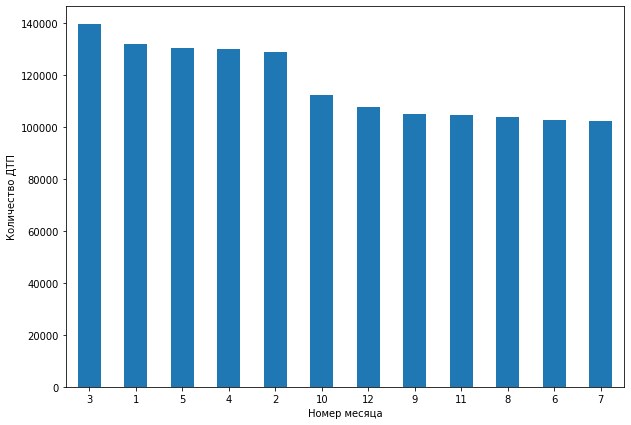

In [18]:
collision_per_month.index = collision_per_month['month']
collision_per_month['collis_cnt'].plot(kind='bar', figsize=(10,7), rot=0)
plt.xlabel('Номер месяца')
plt.ylabel('Количество ДТП')
plt.show()

**Вывод**
- Наибольшее число ДТП - в марте(вероятно могут сказаться обстоятельства смены зимнего сезона, такие как необходимость менять резину)
- Наименьшее количство ДТП в июле
- В первой половине года больше ДТП, чем во второй половине

**Задачи для анализа**

* Какая была погода в день марта 2009 года с самым большим количиством ДТП за месяц.
* Вывести самый большой возраст автомобиля попавшего в ДТП.
* В какой месяц было больше всего ДТП с участием автомобилей с типом кузова MINIVAN?
* Какой процент попадающих в ДТП водителей были в сонном/усталом состоянии?
* Какова максимальная сумма страховки автомобиля, попавшего в аварию.
* Автомобили с каким типом КПП попадают в ДТП реже всего в туманную погоду?

**Решения задач**

В какой месяц было больше всего ДТП с участием автомобилей с типом кузова MINIVAN?

In [19]:
query = '''
SELECT EXTRACT(month FROM collision_date)::int,
       COUNT(DISTINCT(c.case_id))
FROM collisions AS c
LEFT JOIN vehicles AS v ON c.case_id=v.case_id
WHERE vehicle_type = 'minivan'
group by 1
order by 2 DESC
'''

most_sedan_collis = pd.read_sql_query(query, con=engine) 

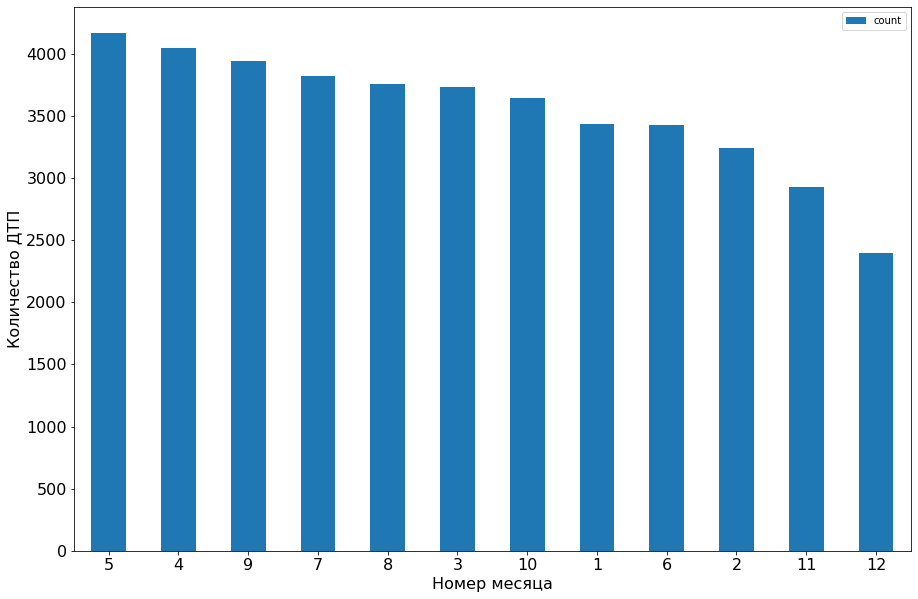

In [20]:
most_sedan_collis.index = most_sedan_collis['date_part']
most_sedan_collis = most_sedan_collis.drop('date_part', axis=1)
most_sedan_collis.plot(kind='bar', figsize=(15,10), rot=0, fontsize=16)
plt.xlabel('Номер месяца', fontsize=16)
plt.ylabel('Количество ДТП', fontsize=16)
plt.show()

Как видно из графика автомобили с типом кузова MINIVAN попадают в аварии чаще всего в мае.

Автомобили с каким типом КПП попадают в ДТП реже всего в туманную погоду?

In [21]:
query = '''
SELECT v.vehicle_transmission,
       COUNT(DISTINCT(c.case_id))
FROM collisions AS c
LEFT JOIN vehicles AS v ON c.case_id=v.case_id
WHERE weather_1 = 'fog'
GROUP BY 1
ORDER BY 2
'''

less_transmis = pd.read_sql_query(query, con=engine) 

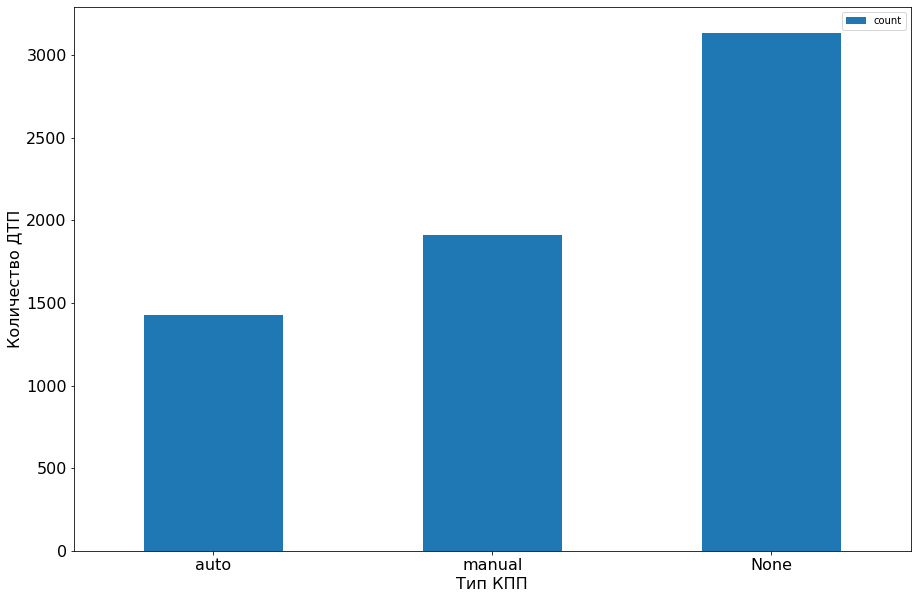

In [22]:
less_transmis.index = less_transmis['vehicle_transmission']
less_transmis = less_transmis.drop('vehicle_transmission', axis=1)
less_transmis.plot(kind='bar', figsize=(15,10), rot=0, fontsize=16)
plt.xlabel('Тип КПП', fontsize=16)
plt.ylabel('Количество ДТП', fontsize=16)
plt.show()

Опираясь на полученный график можно сказать, что автомобили с автоматическим типом КПП попадают в аварии реже остальных в туманную погоду

## Создадим модель для оценки водительского риска

In [23]:
del parties, collisions, less_transmis, most_sedan_collis

* Возьмем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).

* Для моделирования также возьмем данные только за 2012 год.

In [24]:
query = '''
SELECT *
FROM collisions
where collision_damage <> 'scratch' and date_Trunc('year', collision_date)::date = '2012-01-01'
'''

collisions = pd.read_sql_query(query, con=engine) 

In [25]:
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,5457328,3711,san diego,5.0,west,0.0,clear,None,middle damage,2,None,None,broadside,bicycle,dry,normal,daylight,none,2012-01-20,13:30:00
1,5125192,4312,santa clara,30.0,south,0.0,cloudy,None,small damage,2,vehicle code violation,unsafe starting or backing,other,parked motor vehicle,dry,normal,daylight,functioning,2012-03-16,14:35:00
2,5403029,4313,santa clara,0.0,None,1.0,fog,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,None,2012-01-03,07:29:00
3,5403040,4000,san luis obispo,460.0,north,0.0,clear,None,fatal,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,daylight,none,2012-01-01,08:50:00
4,5403042,1942,los angeles,0.0,None,1.0,clear,None,fatal,2,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-03,00:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115661,5461488,1942,los angeles,292.0,north,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,daylight,functioning,2012-01-24,15:30:00
115662,5461486,1910,los angeles,773.0,east,0.0,clear,None,middle damage,2,unknown,unknown,other,other object,dry,normal,daylight,none,2012-01-04,14:47:00
115663,5461622,3711,san diego,528.0,north,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,daylight,none,2012-01-07,16:52:00
115664,5461642,3711,san diego,6.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2012-01-26,16:04:00


* Выберем тип виновника — только машина (car).

In [26]:
query = '''
SELECT *
FROM parties
WHERE party_type = 'car';
'''

parties = pd.read_sql_query(query, con=engine)

In [27]:
query = '''
SELECT *
FROM vehicles
'''

vehicles = pd.read_sql_query(query, con=engine)

**Проведем первичный отбор факторов, необходимых для модели**

In [28]:
columns =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
          'weather_1',      # Погода (может влиять) Таблица collisions
          'road_surface',   # Состояние дороги (может влиять) Таблица collisions
          'lighting',       # Освещение (может влиять) Таблица collisions
          'location_type',  # Тип дороги (может влиять) Таблица collisions
          'road_condition_1',# Дорожное состояние (может влиять) Таблица collisions
          'control_device',
          'party_drug_physical',
          'vehicle_transmission'
          ]

In [29]:
data = collisions.merge(parties.merge(vehicles, how='left', on=['case_id','party_number']), how='inner', on='case_id')

In [30]:
data.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id_y,vehicle_type,vehicle_transmission,vehicle_age
0,5457328,3711,san diego,5.0,west,0.0,clear,None,middle damage,2,...,car,0,23.0,had not been drinking,None,0.0,NaN,NaN,NaN,NaN
1,5125192,4312,santa clara,30.0,south,0.0,cloudy,None,small damage,2,...,car,1,49.0,had not been drinking,None,0.0,NaN,NaN,NaN,NaN
2,5403029,4313,santa clara,0.0,None,1.0,fog,None,fatal,3,...,car,1,25.0,impairment unknown,G,NaN,1274766.0,coupe,auto,4.0
3,5403029,4313,santa clara,0.0,None,1.0,fog,None,fatal,3,...,car,0,18.0,had not been drinking,None,NaN,NaN,NaN,NaN,NaN
4,5403029,4313,santa clara,0.0,None,1.0,fog,None,fatal,3,...,car,0,16.0,had not been drinking,None,NaN,NaN,NaN,NaN,NaN


In [31]:
data.shape

(196837, 32)

**Проведём статистическое исследование отобранных факторов**

In [32]:
data[columns].isna().mean()

party_type              0.000000
party_sobriety          0.018416
weather_1               0.003323
road_surface            0.006467
lighting                0.003663
location_type           0.556196
road_condition_1        0.005807
control_device          0.004943
party_drug_physical     0.872239
vehicle_transmission    0.718605
dtype: float64

In [33]:
data['party_type'].value_counts()

car    196837
Name: party_type, dtype: int64

Признак party_type можно удалить, так как он константный для всех записей и не несет ценности для модели

Изучим остальные переменные и предобработаем их, избавившись от пропусков

In [34]:
data['party_sobriety'] = data['party_sobriety'].fillna('Not Stated party_sobriety')
data['party_sobriety'].value_counts()

had not been drinking                     157684
impairment unknown                         20525
had been drinking, under influence         10270
Not Stated party_sobriety                   3625
had been drinking, impairment unknown       1706
not applicable                              1674
had been drinking, not under influence      1353
Name: party_sobriety, dtype: int64

In [35]:
data['weather_1'] = data['weather_1'].fillna('Not Stated weather_1')
data.loc[data['weather_1']=='other','weather_1'] = 'other weather_1'
data['weather_1'].value_counts()

clear                   157335
cloudy                   29497
raining                   8112
Not Stated weather_1       654
fog                        584
snowing                    433
other weather_1            175
wind                        47
Name: weather_1, dtype: int64

In [36]:
data['road_surface'] = data['road_surface'].fillna('Not Stated road_surface')
data['road_surface'].value_counts()

dry                        175564
wet                         18920
Not Stated road_surface      1273
snowy                         926
slippery                      154
Name: road_surface, dtype: int64

In [37]:
data['lighting'] = data['lighting'].fillna('Not Stated road_surface')
data['lighting'].value_counts()

daylight                                   136370
dark with street lights                     38095
dark with no street lights                  14430
dusk or dawn                                 6775
Not Stated road_surface                       721
dark with street lights not functioning       446
Name: lighting, dtype: int64

In [38]:
data['location_type'] = data['location_type'].fillna('Not Stated location_type')
data['location_type'].value_counts()

Not Stated location_type    109480
highway                      71914
ramp                         11526
intersection                  3917
Name: location_type, dtype: int64

In [39]:
data['road_condition_1'] = data['road_condition_1'].fillna('Not Stated road_condition_1')
data.loc[data['road_condition_1']=='other','road_condition_1'] = 'other road_condition_1'
data['road_condition_1'].value_counts()

normal                         189563
construction                     3355
Not Stated road_condition_1      1143
other road_condition_1            789
obstruction                       729
holes                             626
loose material                    310
reduced width                     217
flooded                           105
Name: road_condition_1, dtype: int64

In [40]:
data['control_device'] = data['control_device'].fillna('Not Stated control_device')
data['control_device'].value_counts()

none                         132665
functioning                   62639
Not Stated control_device       973
not functioning                 444
obscured                        116
Name: control_device, dtype: int64

In [41]:
data['party_drug_physical'] = data['party_drug_physical'].fillna('Not Stated party_drug_physical')
data['party_drug_physical'].value_counts()

Not Stated party_drug_physical    171689
G                                  20525
not applicable                      1674
under drug influence                1516
sleepy/fatigued                     1096
impairment - physical                337
Name: party_drug_physical, dtype: int64

In [42]:
data['vehicle_transmission'] = data['vehicle_transmission'].fillna('Not Stated vehicle_transmission')
data['vehicle_transmission'].value_counts()

Not Stated vehicle_transmission    141448
manual                              29318
auto                                26071
Name: vehicle_transmission, dtype: int64

In [43]:
data['at_fault'].isna().mean()

0.0

In [44]:
data['at_fault'].value_counts()

1    103047
0     93790
Name: at_fault, dtype: int64

Количество записей каждого класса примерно равное, дисбаланс отсутствует

In [45]:
data.vehicle_age.isna().mean()

0.7228468224978027

In [46]:
data = data[data['vehicle_age'] < 10]

In [47]:
data.vehicle_age.isna().mean()

0.0

In [48]:
columns.remove('party_type')

Подготовим датасет для бустингов

In [49]:
features_gb = data[columns].copy()
target = data['at_fault']

In [50]:
features_gb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49471 entries, 2 to 196830
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   party_sobriety        49471 non-null  object
 1   weather_1             49471 non-null  object
 2   road_surface          49471 non-null  object
 3   lighting              49471 non-null  object
 4   location_type         49471 non-null  object
 5   road_condition_1      49471 non-null  object
 6   control_device        49471 non-null  object
 7   party_drug_physical   49471 non-null  object
 8   vehicle_transmission  49471 non-null  object
dtypes: object(9)
memory usage: 3.8+ MB


Все колонки - категориальные

Разобьем датасет на выборки

In [51]:
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(features_gb, target, test_size=0.2, random_state=12345)

Выделим валидационную выборку

In [52]:
X_train_gb, X_valid_gb, y_train_gb, y_valid_gb = train_test_split(X_train_gb, y_train_gb, test_size=0.2, random_state=12345)

Закодируем категориальные параметры и соберем датасет целиком

Подготовим датасет для нейронной сети

In [53]:
full = pd.get_dummies(data['party_sobriety'], drop_first=True)

In [54]:
full = full.merge(pd.get_dummies(data['weather_1'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['road_surface'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['lighting'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['location_type'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['road_condition_1'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['control_device'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['party_drug_physical'], drop_first=True), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(data['vehicle_transmission'], drop_first=True), left_index=True, right_index=True,how='left') 

In [55]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49471 entries, 2 to 196830
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   had been drinking, impairment unknown    49471 non-null  uint8
 1   had been drinking, not under influence   49471 non-null  uint8
 2   had been drinking, under influence       49471 non-null  uint8
 3   had not been drinking                    49471 non-null  uint8
 4   impairment unknown                       49471 non-null  uint8
 5   not applicable_x                         49471 non-null  uint8
 6   clear                                    49471 non-null  uint8
 7   cloudy                                   49471 non-null  uint8
 8   fog                                      49471 non-null  uint8
 9   other weather_1                          49471 non-null  uint8
 10  raining                                  49471 non-null  uint8
 11  s

Разобьем выборку на обучающую и тестовую

In [56]:
X_train, X_test, y_train, test_y = train_test_split(full, data['at_fault'], test_size=0.2, random_state=1234)

In [57]:
print(X_train.shape, X_test.shape)

(39576, 44) (9895, 44)


Выделим валидационную выборку

In [58]:
X_train, X_valid, y_train, y_valid =  train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

In [59]:
print(X_train.shape, X_valid.shape)

(31660, 44) (7916, 44)


**Выбор метрики**

В качестве метрики будем опираться на метрику F1. Мы хотим минимизировать ошибки 2-го рода, т.е. если маршрут потенциально сулит ДТП, то хотим не пропустить это и сообщить клиенту, однако и всегда заставлять клиента перестраивать маршрут не желательно, потому что тогда от продукта нет смысла. Поэтому берем сбалансированную метрику

### Catboost

In [135]:
cat_model = CatBoostClassifier(random_state=12345, cat_features=columns, eval_metric='F1')
# set up our search grid
param_grid = {'custom_loss':['F1'],
              "n_estimators": [200, 600, 800],
              "learning_rate": [0.03, 0.1]}

# try out every combination of the above values
#search = GridSearchCV(cat_model, param_grid, cv=4, scoring='f1').fit(X_train, y_train)

grid_search_result = cat_model.grid_search(param_grid, 
                      X=X_train_gb,
                      y=y_train_gb,
                      plot=True,
                      verbose=False)

#print("The best hyperparameters are:", search.best_params_)
#print("The best score is:", search.best_score_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3628051	test: 0.3906063	best: 0.3906063 (0)	total: 29.8ms	remaining: 5.92s
1:	learn: 0.3712186	test: 0.3906063	best: 0.3906063 (0)	total: 66.6ms	remaining: 6.59s
2:	learn: 0.3715720	test: 0.3906063	best: 0.3906063 (0)	total: 99.8ms	remaining: 6.55s
3:	learn: 0.3732274	test: 0.3907110	best: 0.3907110 (3)	total: 144ms	remaining: 7.05s
4:	learn: 0.4387535	test: 0.4521970	best: 0.4521970 (4)	total: 186ms	remaining: 7.25s
5:	learn: 0.4385627	test: 0.4521970	best: 0.4521970 (4)	total: 203ms	remaining: 6.58s
6:	learn: 0.4329174	test: 0.4458427	best: 0.4521970 (4)	total: 242ms	remaining: 6.67s
7:	learn: 0.4610983	test: 0.4815609	best: 0.4815609 (7)	total: 275ms	remaining: 6.61s
8:	learn: 0.4339384	test: 0.4458427	best: 0.4815609 (7)	total: 320ms	remaining: 6.8s
9:	learn: 0.4615300	test: 0.4816642	best: 0.4816642 (9)	total: 357ms	remaining: 6.79s
10:	learn: 0.4615300	test: 0.4816642	best: 0.4816642 (9)	total: 401ms	remaining: 6.9s
11:	learn: 0.4616738	test: 0.4816642	best: 0.4816642

In [136]:
grid_search_result['params']

{'iterations': 600, 'learning_rate': 0.1, 'custom_metric': 'F1'}

In [139]:
cat_model = CatBoostClassifier(learning_rate=grid_search_result['params']['learning_rate'],
                              n_estimators=grid_search_result['params']["iterations"],
                              custom_loss=grid_search_result['params']["custom_metric"],
                              random_state=12345,
                              cat_features=columns,
                              eval_metric='F1')

In [140]:
cat_model.fit(X_train_gb,
              y_train_gb,
              eval_set=(X_valid_gb, y_valid_gb),
              plot=True)
prediction_catboost = cat_model.predict(X_valid_gb)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3899705	test: 0.4026846	best: 0.4026846 (0)	total: 56.3ms	remaining: 33.7s
1:	learn: 0.3915267	test: 0.4026846	best: 0.4026846 (0)	total: 106ms	remaining: 31.6s
2:	learn: 0.3910420	test: 0.4026846	best: 0.4026846 (0)	total: 129ms	remaining: 25.6s
3:	learn: 0.4629858	test: 0.4721736	best: 0.4721736 (3)	total: 178ms	remaining: 26.6s
4:	learn: 0.4635389	test: 0.4721736	best: 0.4721736 (3)	total: 218ms	remaining: 25.9s
5:	learn: 0.4646429	test: 0.4729942	best: 0.4729942 (5)	total: 261ms	remaining: 25.8s
6:	learn: 0.4661819	test: 0.4740792	best: 0.4740792 (6)	total: 302ms	remaining: 25.6s
7:	learn: 0.4662023	test: 0.4741620	best: 0.4741620 (7)	total: 344ms	remaining: 25.5s
8:	learn: 0.4659684	test: 0.4741620	best: 0.4741620 (7)	total: 378ms	remaining: 24.8s
9:	learn: 0.4661087	test: 0.4741620	best: 0.4741620 (7)	total: 417ms	remaining: 24.6s
10:	learn: 0.4660739	test: 0.4740792	best: 0.4741620 (7)	total: 458ms	remaining: 24.5s
11:	learn: 0.4663367	test: 0.4740792	best: 0.4741620

### LightGBM

In [64]:
X_train.columns = [i.replace('-', ' ').replace('/', ' ').replace(',', '') for i in X_train.columns.values]
X_test.columns = [i.replace('-', ' ').replace('/', ' ').replace(',', '') for i in X_train.columns.values]

In [65]:
X_train_gb = X_train_gb.astype('category')
X_test_gb = X_test_gb.astype('category')
X_valid_gb = X_valid_gb.astype('category')
y_train_gb = y_train_gb.astype('category')
y_test_gb = y_test_gb.astype('category')
y_valid_gb = y_valid_gb.astype('category')

In [66]:
lgbm_model = LGBMClassifier(random_state=12354)
# set up our search grid
param_grid = {"max_depth":    [12],
              "n_estimators": [200, 600],
              "learning_rate": [0.03, 0.07]}

# try out every combination of the above values
search = GridSearchCV(lgbm_model, param_grid, cv=4, scoring='f1').fit(X_train_gb, y_train_gb)

print("The best hyperparameters are ",search.best_params_)
print("The best score is:", search.best_score_)

The best hyperparameters are  {'learning_rate': 0.07, 'max_depth': 12, 'n_estimators': 200}
The best score is: 0.5275038529378102


In [67]:
lgbm_model = LGBMClassifier(learning_rate=search.best_params_["learning_rate"],
                            n_estimators=search.best_params_["n_estimators"],
                            max_depth=search.best_params_["max_depth"],
                            random_state=12345)
lgbm_model.fit(X_train_gb,
               y_train_gb)

prediction_lgbm = lgbm_model.predict(X_valid_gb)

### PyTorch

In [68]:
features_train = torch.FloatTensor(X_train.values.astype('float32'))
features_test = torch.FloatTensor(X_test.values.astype('float32'))
features_valid = torch.FloatTensor(X_valid.values.astype('float32'))
target_train = torch.FloatTensor(y_train.values.astype('float32'))
target_test = torch.FloatTensor(test_y.values.astype('float32'))
target_valid = torch.FloatTensor(y_valid.values.astype('float32'))

In [69]:
features_train.size()

torch.Size([31660, 44])

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense0 = nn.Linear(44, 87)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(0)
        self.dense1 = nn.Linear(87, 50)
        self.act2 = nn.ReLU()
        self.dense2 = nn.Linear(50, 32)
        self.act3 = nn.ReLU()
        self.dense3 = nn.Linear(32, 11)
        self.act4 = nn.ReLU()
        self.dense4 = nn.Linear(11, 1)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.act1(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.act2(X)
        X = self.dense2(X)
        X = self.act3(X)
        X = self.dense3(X)
        X = self.act4(X)
        X = F.softmax(self.dense4(X), dim=1)
        return X

In [71]:
learning_rate = 1e-2

In [72]:
net = Net()

In [73]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss = nn.BCELoss()

num_epochs = 100

In [74]:
#for epoch in range(num_epochs):
#    optimizer.zero_grad()
#    
#    preds = net.forward(features_train).flatten()
#            
#    loss_value = loss(preds, target_train)
#    print(loss_value)
#    loss_value.backward()
#            
#    optimizer.step()
#    
#    if epoch % 10 == 0 or epoch == num_epochs - 1:
#        net.eval()
#        valid_preds = net.forward(features_valid)
#        valid_preds = valid_preds.squeeze()
#        #print(f1_score(test_y, test_preds.detach().numpy()))

In [75]:
#valid_preds

In [76]:
#sum(valid_preds.detach().numpy())

In [141]:
print('-----------prediction_catboost:\n')
print(classification_report(y_valid_gb, prediction_catboost))
print('--------------------------------')
print('-----------prediction_lgbm:\n')
print(classification_report(y_valid_gb, prediction_lgbm))
print('--------------------------------')
#print('-----------нейронка:\n')
#print(classification_report(y_valid, valid_preds.detach().numpy()))
#print('--------------------------------')

-----------prediction_catboost:

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      3892
           1       0.71      0.45      0.55      4024

    accuracy                           0.63      7916
   macro avg       0.65      0.63      0.62      7916
weighted avg       0.65      0.63      0.62      7916

--------------------------------
-----------prediction_lgbm:

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      3892
           1       0.71      0.45      0.55      4024

    accuracy                           0.63      7916
   macro avg       0.65      0.63      0.61      7916
weighted avg       0.65      0.63      0.61      7916

--------------------------------


Опираясь на полученные метрики лучшей моделью является catboost, хотя модели и очень близки по качеству

Проверим лучшую модель на тестовой выборке

In [142]:
best_model_test = cat_model.predict(X_test_gb)

In [143]:
print(classification_report(y_test_gb, best_model_test))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68      4936
           1       0.70      0.46      0.55      4959

    accuracy                           0.63      9895
   macro avg       0.65      0.63      0.62      9895
weighted avg       0.65      0.63      0.62      9895



Confusion matrix, without normalization
[[3955  981]
 [2700 2259]]


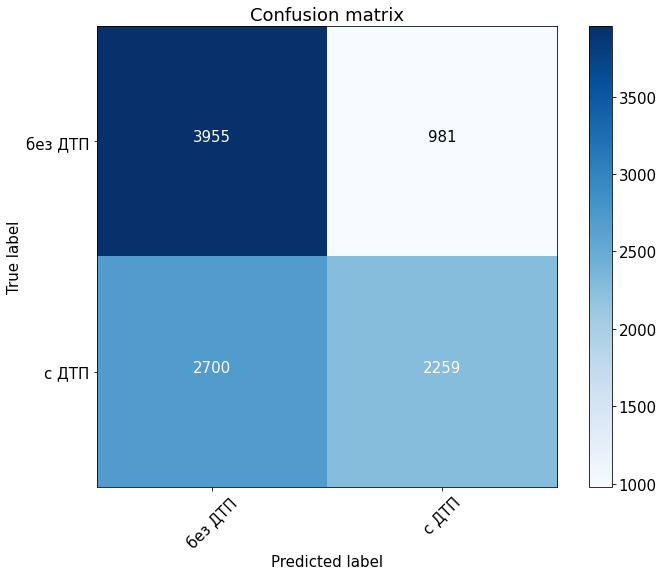

In [144]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_gb, best_model_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['без ДТП', 'с ДТП'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Проведём анализ важности факторов ДТП

In [145]:
df = pd.DataFrame(columns=columns)
df.loc[len(df.index)] = list(cat_model.feature_importances_)

In [146]:
df.T.sort_values(0,ascending=0)

,0
party_sobriety,41.602129
party_drug_physical,10.783114
lighting,7.913484
road_surface,7.851849
location_type,7.768280
vehicle_transmission,7.156922
control_device,6.777610
weather_1,5.508279
road_condition_1,4.638334


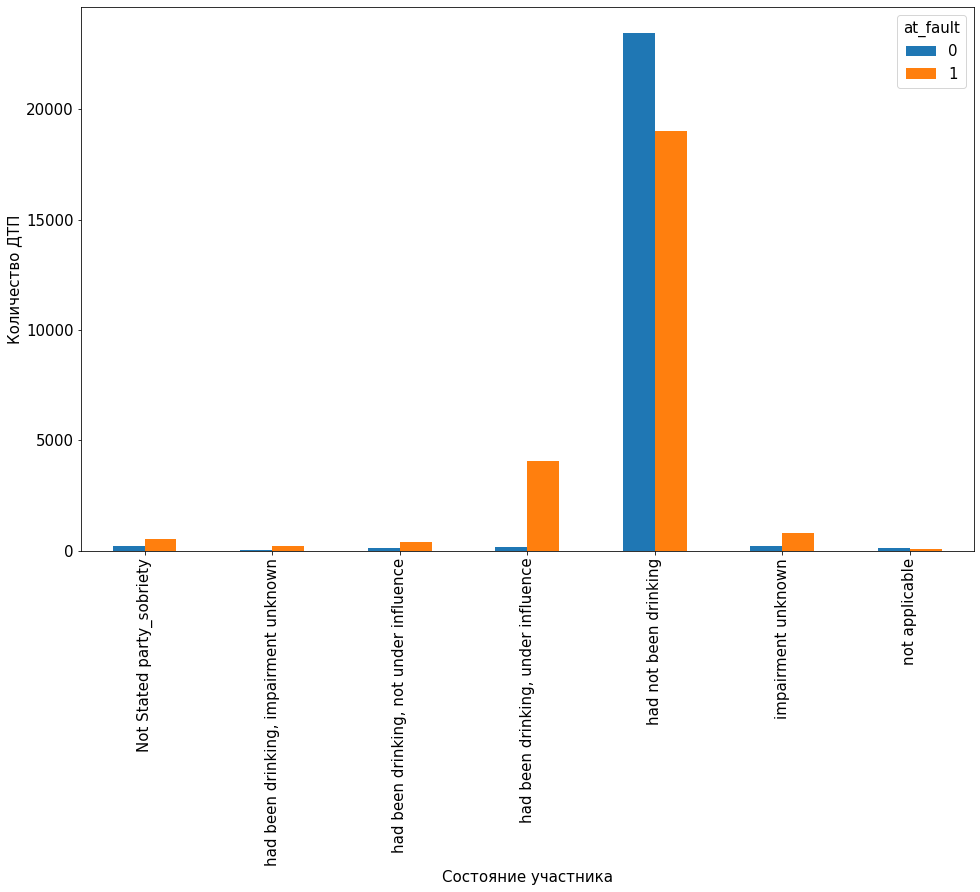

In [147]:
pd.crosstab(data['party_sobriety'],data['at_fault']).plot(kind='bar',figsize=(16,10))
plt.xlabel('Состояние участника')
plt.ylabel('Количество ДТП')
plt.show()

Опираясь на полученный график можно заметить, что если участник выпил, или его состояние неизвестно, то чаще всего автомобиль попадет в ДТП. 

Нужно оборудовать автомобиль тестером на состояние акогольного опьянения у водителя. 

## Выводы

Лучшей моделью получилась модель catboost: она лучше всех определяет и находит автомобиль с возможным ДТП.

На данный момент определяет машины с ДТП меньше половины из всех возможных правильно, если улучшить метрики вполне адекватно можно использовать эту модель.

Чтобы улучшить модель можно добавить данные о техническом состаянии автомобиля, его возрасте.